In [1]:
import pandas as pd
import numpy as np 
import rasterio
import rioxarray
import matplotlib.pyplot as plt 
import xarray as xr
import math
import seaborn as sns
sns.set()
sns.set_context("notebook")

class Analysis:
    def __init__(self) -> None:
        pass

    def get_pred_h(self, results):
        self.rf_results = rioxarray.open_rasterio(results, band_as_variable=True)
        
    def set_ground_truth(self, gt_tif):
        self.ground_truth = rioxarray.open_rasterio(gt_tif, band_as_variable=True)

    def set_test_data(self, test_data_tif):
        self.test_data = rioxarray.open_rasterio(test_data_tif, band_as_variable=True)
        return self.test_data
    
    def set_test_data2(self, test_data_tif):
        self.test_data2 = rioxarray.open_rasterio(test_data_tif, band_as_variable=True)
        return self.test_data2
    
    def get_difference(self):
        self.ground = self.ground_truth.rio.reproject_match(self.test_data)
        # self.ground = self.test_data.rio.reproject_match(self.ground_truth)
        self.difference = self.ground - self.test_data
        return self.difference 
    
    def calc_rmse(self):
        diff = self.test_data - self.ground
        diff_sq = diff ** 2
        mean = diff_sq.band_1.mean()
        rmse = math.sqrt(mean)
        return rmse

In [7]:
tasman_ground_truth = '../ICESAT/tasmania/gnd_dem_02.tif'
# tasman_pred_laplace = '../ICESAT/tasmania/features_tmp/interp_laplace_h.tif'
tasman_pred_idw = '../ICESAT/tasmania/features_tmp/unused/interp_idw_h.tif'
tasman_pred_tin = '../ICESAT/tasmania/tasmania_tin.tif'
tasman_pred_nni = '../ICESAT/tasmania/tasmania_nni.tif'
tasman_pred_rf = '../ICESAT/tasmania/results/tasmania_pred_sklearn.tif'
tasman_relativeh = '../ICESAT/tasmania/results/tasmania_nearest_h_sklearn_relativeh.tif'
tasman_geometric_features = '../ICESAT/tasmania/results/tasmania__sklearn_geometric.tif'
tasman_ensamble = '../ICESAT/tasmania/results/tasmania_sklearn_ensamble.tif'
tasman_icesat_geom = '../ICESAT/tasmania/results/tasmania_icesat_sklearn_geometric.tif'


In [ ]:
# tasman = Analysis()
# tasman_ground_truth = '../ICESAT/tasmania/gnd_dem_02.tif'
# tasman.set_ground_truth(tasman_ground_truth)
# tasman.set_test_data(tasman_ensamble)
# tasman.set_test_data2(tasman_pred_laplace)

# # tasman.difference.band_1.plot()

# def get_diff(dataset_ground, dataset_test):
#     dataset_ground = dataset_ground.rio.reproject_match(dataset_test)
#     difference = dataset_ground - dataset_test
#     return difference 

# # Crop Test Data
# tasman_dataset1 = tasman.test_data.sel(
#     x=slice(tasman.ground_truth['x'].min()+100, tasman.ground_truth['x'].max()-100),
#     y=slice(tasman.ground_truth['y'].min()+100, tasman.ground_truth['y'].max()-100)
# )

# tasman.ground_truth.band_1.plot(cmap='gist_earth', robust=True, vmin=-30.12726656, vmax=1000)
# plt.title('Ground Truth')
# plt.xticks(rotation=45)


# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

# tasman.test_data.band_1.plot(cmap='gist_earth', robust=True, ax=axes[0], vmin=-30.12726656, vmax=1000)
# axes[0].set_title('TIN interpolation')

# difference = get_diff(tasman.ground_truth, tasman.test_data)
# difference.band_1.plot(cmap='RdBu', ax=axes[1])
# axes[1].set_title('Difference Error')

# for ax in axes:
#     ax.tick_params(axis='x', rotation=45)
#     ax.set_xlabel('x')
#     ax.set_ylabel('y')

# # Adjust space between subplots
# plt.suptitle("Tasmania: TIN interpolation", fontsize=20)
# plt.tight_layout()
# plt.show()

# difference = difference.band_1.to_numpy()
# difference.flatten()
# difference = difference[~np.isnan(difference)]

# print(np.min(difference))
# print(np.max(difference))
# print(np.median(difference))
# print("mean", np.mean(difference))
# print("std", np.std(difference))

# rmse = math.sqrt(np.mean(difference**2))
# print("rmse", rmse)


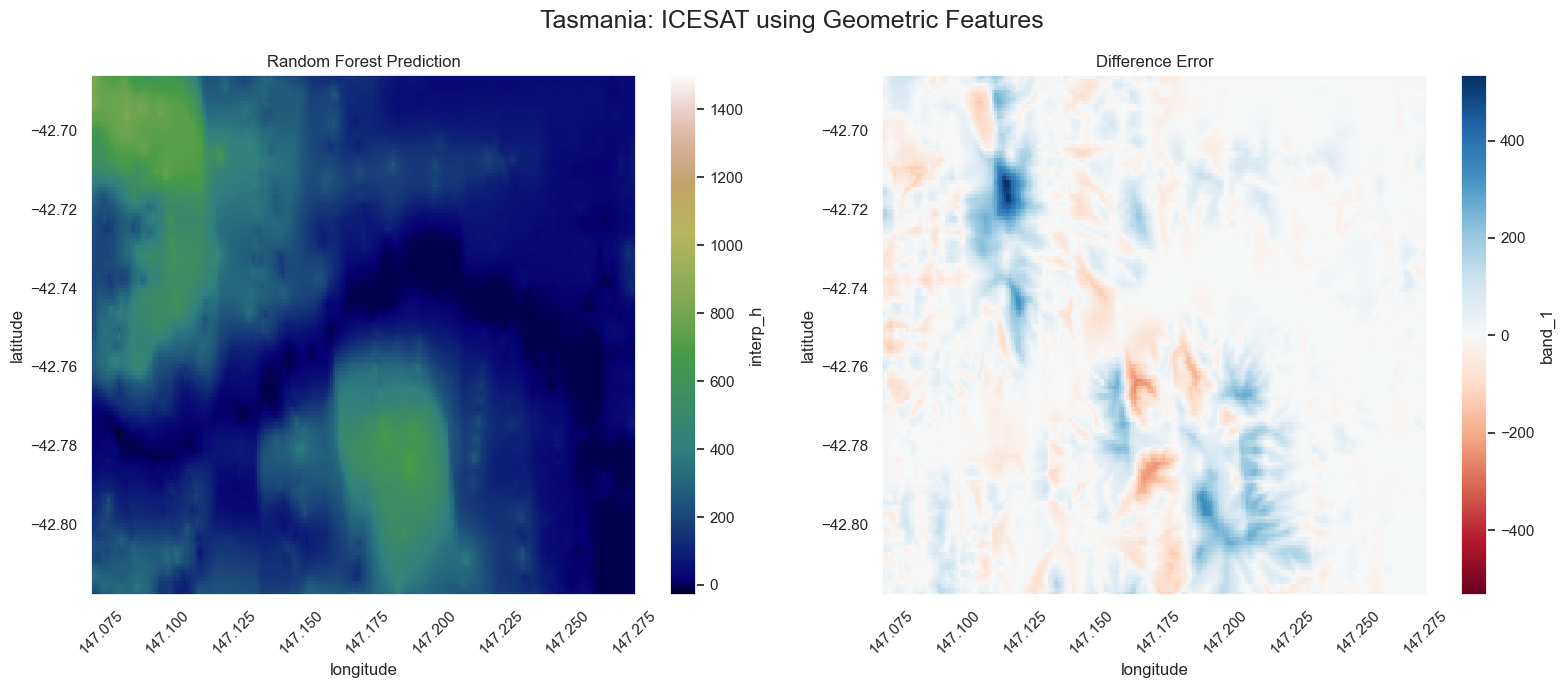

min diff: -255.8025799032753
max diff: 533.9292639090314
median diff: 3.8033634610329337
std: 62.7441338897966
mean diff: 18.131735978644965
rmse 65.31145525235225


In [8]:
tasman = Analysis()
tasman_ground_truth = '../ICESAT/tasmania/gnd_dem_02.tif'
tasman.set_ground_truth(tasman_ground_truth)
tasman.set_test_data(tasman_pred_idw)
# tasman.set_test_data2(tasman_pred_laplace)
# tasman.difference.band_1.plot()

def get_diff(dataset_ground, dataset_test):
    dataset_ground = dataset_ground.rio.reproject_match(dataset_test)
    difference = dataset_ground - dataset_test
    return difference

# Crop Test Data
tasman_dataset1 = tasman.test_data.sel(
    x=slice(tasman.ground_truth['x'].min()+0.01, tasman.ground_truth['x'].max()-0.01),
    y=slice(tasman.ground_truth['y'].min()+0.01, tasman.ground_truth['y'].max()-0.01)
)
# tasman_dataset2 = tasman.test_data2.sel(
#     x=slice(tasman.ground_truth['x'].min()+0.01, tasman.ground_truth['x'].max()-0.01),
#     y=slice(tasman.ground_truth['y'].min()+0.01, tasman.ground_truth['y'].max()-0.01)
# )

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

tasman_dataset1.band_1.plot(cmap='gist_earth', robust=True, ax=axes[0], vmin=-30.12726656, vmax=1500)
axes[0].set_title('Random Forest Prediction')

difference = get_diff(tasman.ground_truth, tasman_dataset1)
difference.band_1.plot(cmap='RdBu', ax=axes[1])
axes[1].set_title('Difference Error')

for ax in axes:
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')

# Adjust space between subplots
plt.suptitle("Tasmania: ICESAT using Geometric Features", fontsize=18)
plt.tight_layout()
plt.show()

difference = difference.band_1.to_numpy()
difference.flatten()
print("min diff:", np.min(difference))
print("max diff:", np.max(difference))
print("median diff:", np.median(difference))
print("std:",np.std(difference))
print("mean diff:",np.mean(difference))
rmse = math.sqrt(np.mean(difference**2))
print("rmse", rmse)


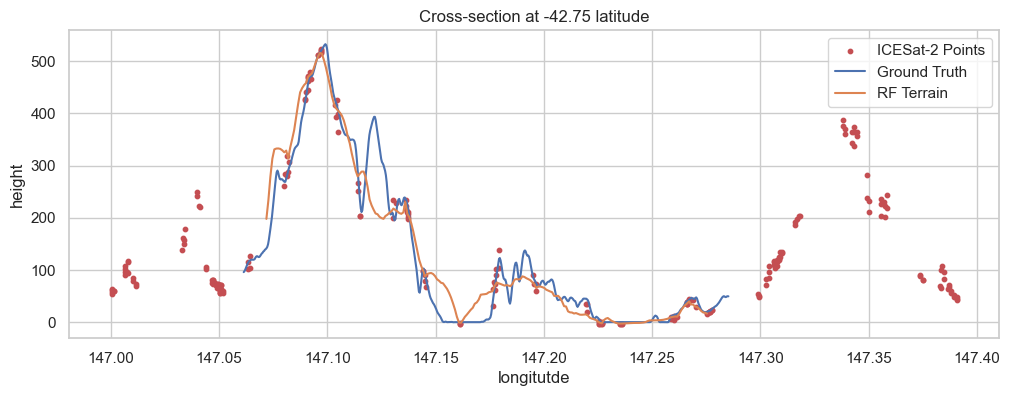

In [66]:
# cross_section_gnd = tasman_gnd.sel(y=-42.80, method='nearest')
# cross_section_test = tasman_dataset1.sel(y=-42.80, method='nearest')

taz = r"../ICESAT/tasmania/tasmania.csv"
icesat = pd.read_csv(taz)
lats = icesat['lat'][:]
lons = icesat['lon'][:]
elevations = icesat['h_te_interp'][:]

target_lat = -42.75
tolerance = 0.001 # Tolerance range (+/- 0.2 degrees)

indices = np.where((lats >= target_lat - tolerance) & (lats <= target_lat + tolerance))
# Extract data for the selected latitude range
s_lons = lons[indices[0]]
s_elev = elevations[indices[0]]

# tasman_dataset1.band_1.plot(label="ground truth")
mask = tasman.ground_truth != -9999
filtered_data = tasman.ground_truth.where(mask, drop=True)


# filtered_data.band_1.plot(label="ground truth")
cross_section_gnd = filtered_data.sel(y=target_lat, method='nearest')
cross_section_test = tasman_dataset1.sel(y=target_lat, method='nearest')
# cross_section_laplace = tasman_dataset2.sel(y=target_lat, method='nearest')


# icesatpoints = pd.read_csv('../ICESAT/tasmania/tasmania.csv')
# measurement_x = icesatpoints['lon'].values
# measurement_y = icesatpoints['lat'].values
# mask = np.abs(measurement_y - -42.71) <= 0.1

# target_y = -42.70
# tolerance = 0.01

# Filter the y-axis values based on the mask
# filtered_x = measurement_x[(measurement_y >= target_y - tolerance) & (measurement_y <= target_y + tolerance)]
# filtered_y = measurement_y[(measurement_y >= target_y - tolerance) & (measurement_y <= target_y + tolerance)]

plt.figure(figsize=(12, 4))
plt.scatter(s_lons, s_elev, s=10, c='r', label='ICESat-2 Points')

# plt.scatter(filtered_x, filtered_y, c='red', marker='o', label='Measurements', s=1)
cross_section_gnd.band_1.plot(label="Ground Truth")
cross_section_test.band_1.plot(label="RF Terrain")

# cross_section_laplace.band_1.plot(label="Laplace Interpolation")
plt.legend()
plt.xlabel('longitutde')
plt.ylabel('height')
plt.title(f'Cross-section at {target_lat} latitude')

plt.show()

In [ ]:
icesatpoints = pd.read_csv('../ICESAT/tasmania/tasmania.csv')
x = icesatpoints['lon'].values
y = icesatpoints['lat'].values

difference = get_diff(tasman.ground_truth, tasman_dataset1)

difference.band_1.plot(cmap='RdBu', robust=False)
plt.scatter(x, y, marker='.', c='r', s=1, label='ICESat-2 Points')
plt.legend(loc='upper left', fontsize='small')
plt.xticks(rotation=45)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("Tasmania ICESat-2 Points")
plt.show()

In [ ]:
## Error Metrics
tasmaniapoints = pd.read_csv('../ICESAT/tasmania/tasmania.csv', delimiter=',')
x = tasmaniapoints['lon'].values
y = tasmaniapoints['lat'].values

tasman_dataset1.band_1.plot(cmap='gist_earth', robust=True, vmin=0)
plt.scatter(x, y, marker='.', c='r', s=1, label='ICESat-2 Points')
plt.legend(loc='upper left', fontsize='small')
plt.xticks(rotation=45)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("Tasmania ICESat-2 Points")
plt.show()

In [ ]:
Diff = tasman.difference.band_1.to_numpy()
Diff.flatten()
Diff = Diff[~np.isnan(Diff)]
print("Max", np.max(Diff))
print("Min", np.min(Diff))
print("Median", np.median(Diff))
print("STD", np.std(Diff))